In [49]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
from lml import LML

from copy import deepcopy

from model.layers import KHopfield

# set auto reload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
# upload mnist


import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
from lml import LML

from copy import deepcopy

from model.layers import KHopfield





In [3]:
# get first k images and store in k x 28**2 matrix
def get_k_images(k, loader):
    images = []
    labels = []
    for i, (image, label) in enumerate(loader):
        if i == k:
            break
        images.append(image.view(-1, 28**2))
        labels.append(label)

    images = torch.cat(images, dim=0)
    labels = torch.cat(labels, dim=0)
    return images, labels


In [4]:
images, labels = get_k_images(100, load_mnist())

In [5]:
images.shape, labels.shape

(torch.Size([6400, 784]), torch.Size([6400]))

In [6]:
def get_dists(X, x):
    # X in 1 x N x n
    # x in 1 x n x 1
    #return X @ x
    print(X.shape, x.T.shape)
    # add batch dimension to X

    return torch.cdist(X.unsqueeze(0), x.t().unsqueeze(0), p=2).squeeze(0) **2

In [7]:
def get_dists_batch(Xi, x):
    # Xi in N x n
    # x in b x n


    # Duplicate Xi b times
    Xi = Xi.unsqueeze(0).repeat(x.shape[0], 1, 1)

    # add third dimension to x
    x = x.unsqueeze(1)


    #return X @ x
    print(Xi.shape, x.T.shape)
    # add batch dimension to X

    dists = torch.cdist(Xi, x)
    return dists.squeeze(2) **2


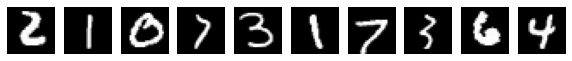

In [8]:
# print first 10 images
fig = plt.figure(figsize=(10, 10))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(images[i].view(28, 28), cmap='gray')
    plt.axis('off')

In [9]:
def ssm(x, k, beta):
    # x in b x n
    return LML(N=k, n_iter = 200,eps = 1e-3)(beta * x)


In [10]:
x =  torch.randn(2, 784)

In [11]:
LML(N=2, n_iter = 200,eps = 1e-3)(1 * x)

tensor([[0.0008, 0.0024, 0.0004,  ..., 0.0017, 0.0016, 0.0020],
        [0.0038, 0.0024, 0.0021,  ..., 0.0039, 0.0024, 0.0054]])

In [39]:
def hopfield(Xi,  x, beta):
    # x is 1 x n

    return  Xi.t() @ torch.softmax(-1*beta * get_dists(Xi, x), dim=0)

In [40]:
def hopfield_batch(Xi,  x, beta):
    # Xi is N x n
    # x is b x n

    return  torch.softmax(-1*beta * get_dists_batch(Xi, x), dim=1) @ Xi

In [41]:
images[0:2].shape

torch.Size([2, 784])

In [42]:
y = k_hopfield_batch(images[3:], images[0:2], 1, k=3)

torch.Size([2, 6397, 784]) torch.Size([784, 1, 2])
torch.Size([2, 6397, 784]) torch.Size([784, 1, 2])
torch.Size([2, 6397, 784]) torch.Size([784, 1, 2])
torch.Size([2, 6397, 784]) torch.Size([784, 1, 2])


In [29]:
def k_softmax_batch(beta, x, k):
    # x is b x N
    # beta is scalar
    # k is int
    # returns b x N x k
    assert(k>=1)
    result = torch.zeros(x.shape[0], x.shape[1], k)
    result[:, :, 0] = torch.softmax(beta * x, dim=1)
    last_ssm = result[:, :, 0]
    for i in range(1, k):
        new_ssm  = ssm(x, i+1, beta)
        result[:, :, i] = new_ssm - last_ssm
        last_ssm = new_ssm
    return result

def k_hopfield_batch(Xi, x, beta, k, hopfield_steps=1):
    # Xi is N x n
    # x is b x n
    # beta, k are scalar
    assert(Xi.shape[1] == x.shape[1])

    dists = get_dists_batch(Xi, x)
    # dists is b x N
    ksm = k_softmax_batch(beta, -1 *dists, k)
    # ksm is b x N x k
    # multiply Xi.t() by all b slices of ksm
    # result is b x n x k
    result = Xi.t() @ ksm

    for i in range(hopfield_steps):
        for j in range(k):
            result[:, :, j] = hopfield_batch(Xi, result[:, :, j], beta)
    return result

In [22]:
def k_softmax(beta, x, k):
    #beta: int, x: N x 1
    # returns N x k
    assert (k >=1)
    result = torch.zeros(x.shape[1], k)
    result[:, 0] = torch.softmax(beta * x, dim=1)
    last_ssm = result[:, 0] 
    for i in range(1, k):
        new_ssm  = ssm(x, i+1, beta)
        result[:, i] = new_ssm - last_ssm
        last_ssm = new_ssm
    return result

def k_hopfield(Xi, x, beta, k, hopfield_steps = 1):
    # Xi: N x n, beta: int, x in nx1
    assert (Xi.shape[1] == x.shape[1])

    dists = get_dists(Xi, x.t()).t()
    k_states =  Xi.t() @ k_softmax(beta, -1* dists, k)


    assert (k_states.shape[0] == Xi.shape[1])
    assert (k_states.shape[1] == k)
    new_states = k_states
    for i in range(hopfield_steps):
        for j in range(k):
            new_states[:, j:j+1]= hopfield(Xi=Xi, x = k_states[:,j:j+1], beta =beta)
    return new_states

In [50]:
x = torch.randn(1, 10)
k_s = k_softmax(1, x, 3)
x

tensor([[ 0.9605, -1.0517, -0.1274, -3.0972,  0.3233,  0.5971, -0.2229,  1.8284,
         -0.1699, -0.9927]])

In [18]:
k_s

NameError: name 'k_s' is not defined

In [38]:
k_s.sum(dim=0)

tensor([1.0000, 1.0000, 1.0000])

In [52]:
LML(N=1, n_iter = 600)(x)

tensor([[0.1216, 0.1228, 0.0540, 0.0471, 0.0629, 0.2350, 0.0735, 0.0203, 0.1644,
         0.0985]])

In [53]:
torch.softmax(x, dim=1)

tensor([[0.1188, 0.1201, 0.0490, 0.0424, 0.0577, 0.2636, 0.0681, 0.0178, 0.1688,
         0.0937]])

(-0.5, 27.5, 27.5, -0.5)

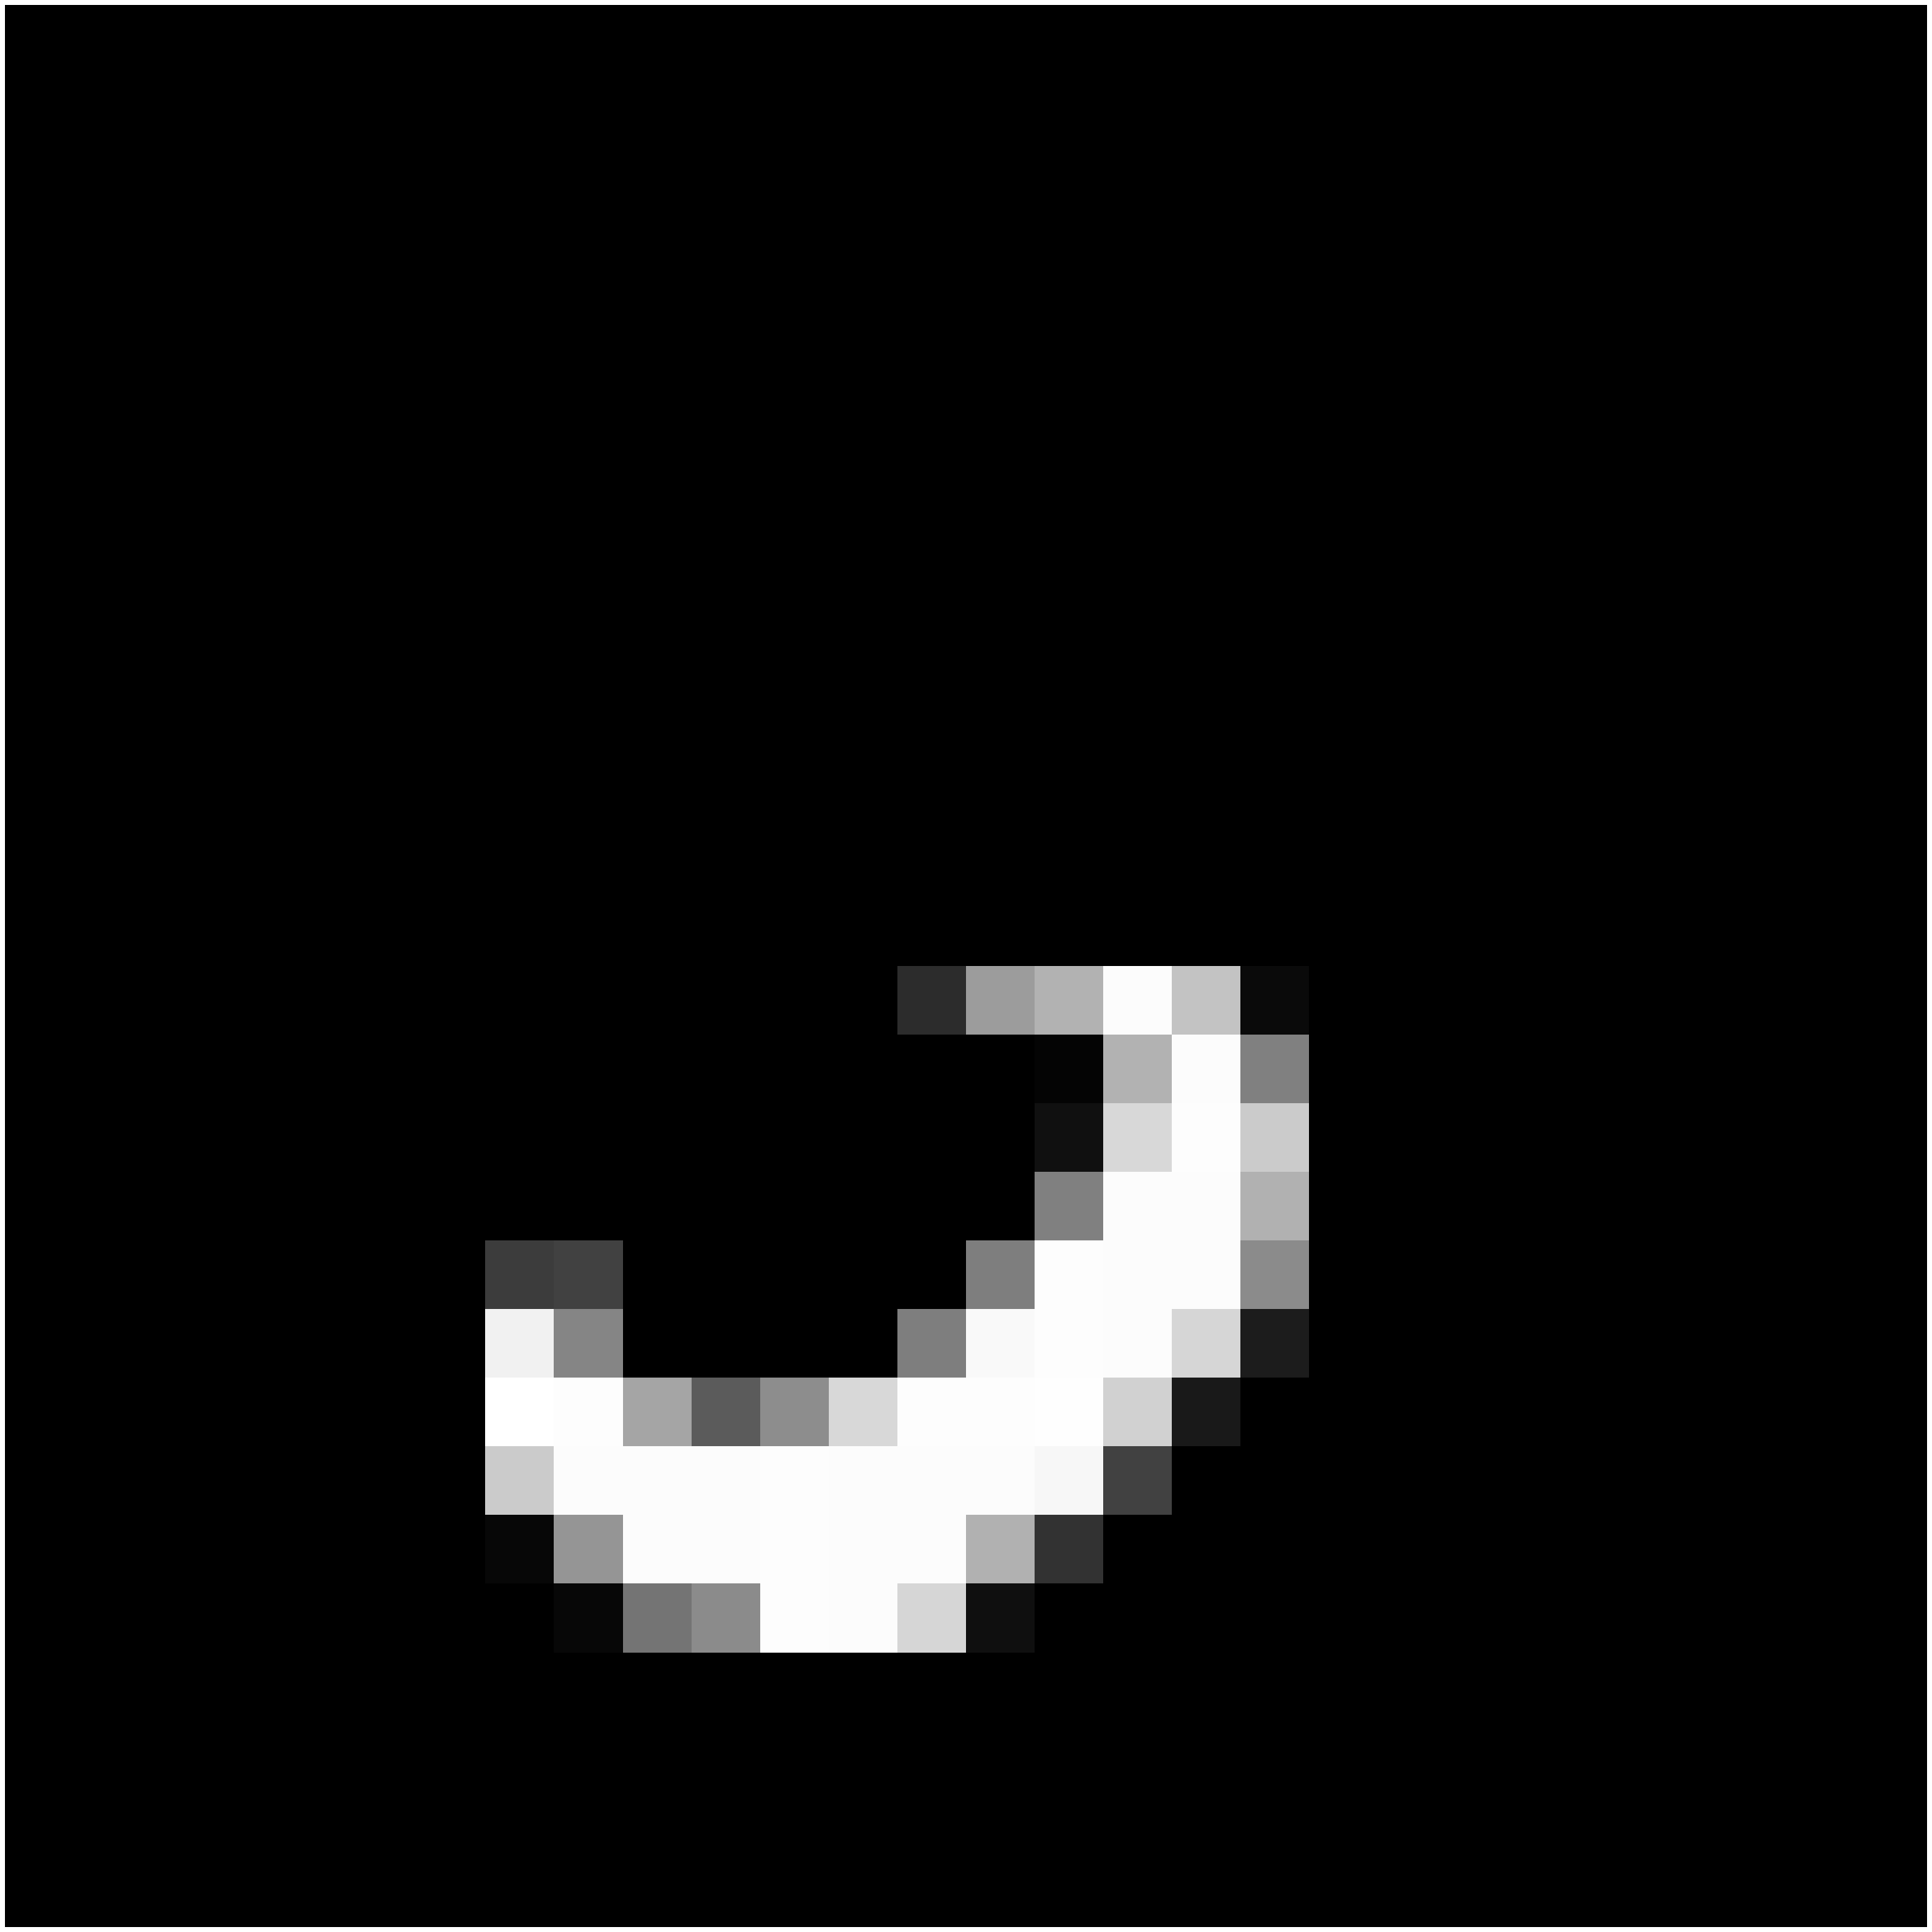

In [43]:
n = 790
X = deepcopy(images[n:n+1])

# oclude top half of image
X[:, :28**2//2] = torch.min(X)
# display X
fig = plt.figure(figsize=(50, 50))

plt.imshow(X.view(28, 28), cmap='gray')
plt.axis('off')
    

In [56]:
KHLayer = KHopfield(1500, images.shape[1])
KHLayer.set_memories(images[0:1500])

torch.Size([1, 1500, 784]) torch.Size([784, 1, 1])
torch.Size([1, 1500, 784]) torch.Size([784, 1, 1])
torch.Size([1, 1500, 784]) torch.Size([784, 1, 1])
torch.Size([1, 1500, 784]) torch.Size([784, 1, 1])
torch.Size([1, 1500, 784]) torch.Size([784, 1, 1])
torch.Size([1, 1500, 784]) torch.Size([784, 1, 1])
torch.Size([1500, 784]) torch.Size([1, 784])
torch.Size([1500, 784]) torch.Size([1, 784])
torch.Size([1500, 784]) torch.Size([1, 784])
torch.Size([1500, 784]) torch.Size([1, 784])
torch.Size([1500, 784]) torch.Size([1, 784])
torch.Size([1500, 784]) torch.Size([1, 784])
torch.Size([1500, 784]) torch.Size([1, 784])
torch.Size([1500, 784]) torch.Size([1, 784])
torch.Size([1500, 784]) torch.Size([1, 784])
torch.Size([1500, 784]) torch.Size([1, 784])
torch.Size([1500, 784]) torch.Size([1, 784])


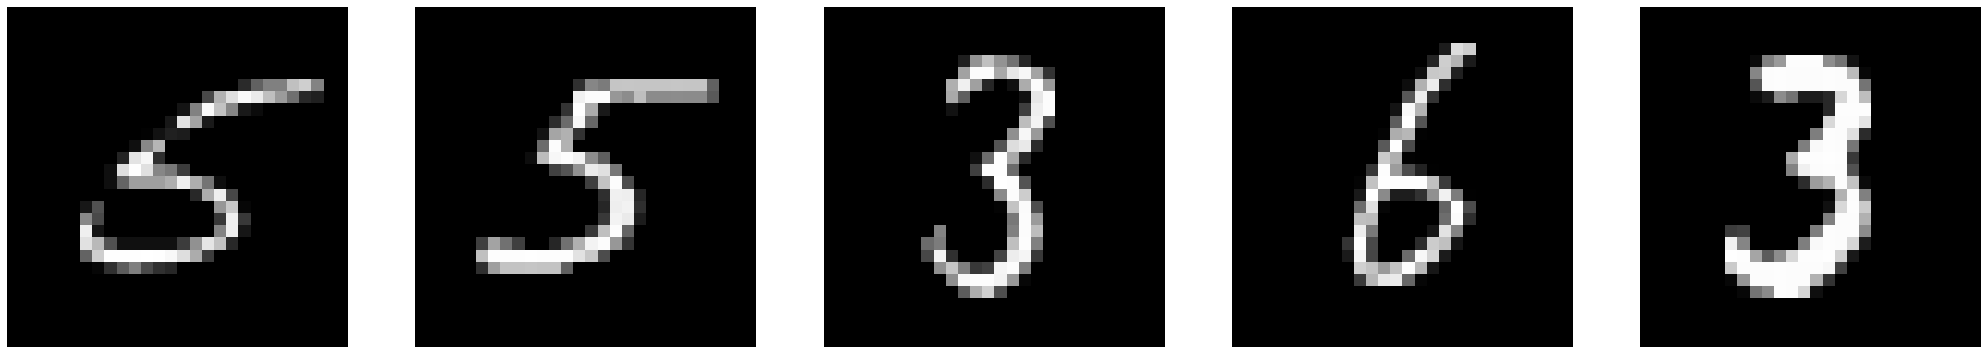

In [64]:

y = k_hopfield_batch(Xi=images[0:1500], x=X, beta = 5,  k=5, hopfield_steps=1)
y = k_hopfield(Xi=images[0:1500], x=X, beta = 5,  k=5, hopfield_steps=2).unsqueeze(0)
y == KHLayer(X, k=1, hopfield_steps = 2)

# display y
fig = plt.figure(figsize=(50, 50))
for i in range(y[0].shape[1]):
    plt.subplot(1, 7, i+1)
    plt.imshow(y[0,:,i].view(28, 28), cmap='gray')
    plt.axis('off')

In [186]:
y = hopfield(Xi=images[0:10], x=images[0:1].t(), beta = 10)

torch.Size([10, 784]) torch.Size([1, 784])


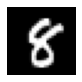

In [187]:
# display y
fig = plt.figure(figsize=(10, 10))
for i in range(y.shape[1]):
    plt.subplot(1, 7, i+1)
    plt.imshow(y[:,i].view(28, 28), cmap='gray')
    plt.axis('off')
    

# Optimization code

In [12]:
import cvxpy as cp
import torch
from cvxpylayers.torch import CvxpyLayer


In [81]:
k = 2
n = 28**2
N = 500
y = cp.Variable(N)
x = cp.Parameter(N)

objective = cp.Minimize( -x.T @ y  - cp.sum(cp.entr(y)   + cp.entr(1 - y)) )
constraints = [cp.sum(y) == k, y >= 0, y <= 1]
problem = cp.Problem(objective, constraints)
assert problem.is_dpp()

In [82]:
cvxpylayer = CvxpyLayer(problem, parameters=[x], variables=[y])

TypeError: get_problem_data() got an unexpected keyword argument 'solver_opts'

In [77]:
weights = X[0] @ images[0:N].t()
# convert weights to numpy array
weights = weights.detach().numpy()
x.value = weights


In [78]:
problem.solve(requires_grad=True)

inf

In [79]:
y.value

array([ 1.00000001e+00,  9.19053634e-09,  9.37982119e-09,  9.43473332e-09,
        9.27597622e-09,  9.56408669e-09,  9.18154610e-09,  9.64285084e-09,
        9.23791129e-09,  9.42653823e-09,  9.35713666e-09,  9.31930806e-09,
        9.31860960e-09,  9.47284391e-09,  9.20218743e-09,  9.34550173e-09,
        9.50684783e-09,  9.51071237e-09,  9.12773035e-09,  9.34028945e-09,
        9.06327908e-09,  9.21979901e-09,  9.21531531e-09,  9.28070605e-09,
        9.56474830e-09,  9.36076982e-09,  9.22636973e-09,  9.39750865e-09,
        9.31242041e-09,  9.26261665e-09,  9.20239709e-09,  9.43567913e-09,
        9.52758516e-09,  9.28128505e-09,  9.24928922e-09,  9.27058026e-09,
        9.06928073e-09,  9.26678703e-09,  9.30561845e-09,  9.28434121e-09,
        9.42795735e-09,  9.41556355e-09,  9.30806875e-09,  9.33023398e-09,
        9.40264871e-09,  9.31997673e-09,  9.32368954e-09,  9.05683065e-09,
        9.26653041e-09,  9.36989599e-09,  9.32047647e-09,  9.47370263e-09,
        9.25921696e-09,  

In [22]:
X[0].shape, images[0:500].shape

(torch.Size([784]), torch.Size([500, 784]))

(-0.5, 27.5, 27.5, -0.5)

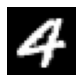

In [21]:
# display X[0]
fig = plt.figure(figsize=(10, 10))
plt.subplot(1, 7, 1)
plt.imshow(X[0].view(28, 28), cmap='gray')
plt.axis('off')


In [65]:
# generate an mnist dataset where each x is a vector of length 794 and the last 10 digits are the one hot encoding of the label
def load_mnist_794():
    # load mnist
    mnist = datasets.MNIST('../data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ]))
    # create new dataset
    mnist_794 = []
    for x, y in mnist:
        # convert x to vector
        x = x.view(-1)
        # convert y to one hot encoding
        y = torch.nn.functional.one_hot(torch.tensor(y), num_classes=10).view(-1)
        # concatenate x and y
        x = torch.cat([x, y])
        mnist_794.append(x)
    mnist_794 = torch.stack(mnist_794)
    return mnist_794
